## Assignment 3
### Creating Composites of AVISO Altimetry Data


<div class="alert alert-block alert-info">
Import Necessary Modules
</div>

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

<div class="alert alert-block alert-info">
Read in Data
</div>

In [3]:
# Import AVISO Data
ds_aviso=xr.open_dataset('monthly_aviso.nc')
ds_aviso

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 276)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
Data variables:
    sla        (time, latitude, longitude) float64 ...

In [4]:
# Tropical Northern Atlantic (TNA) SST Indice Data
# Have to convert into usable xarray dataset
path_tna = "/shared/ccsm4/kpegion/obs2/CLIM_INDICES/"
file_tna = 'tna.data'
index_name = 'tna'

df = df=pd.read_table(path_tna+file_tna,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [5]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [6]:
dates = pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', length=864, freq='MS')

In [7]:
tna_index=df.T.unstack().values

In [8]:
ds_tna=xr.DataArray(tna_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_tna=ds_tna.to_dataset(name='tna')
ds_tna

<xarray.Dataset>
Dimensions:  (time: 864)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2019-12-01
Data variables:
    tna      (time) float64 0.16 -0.01 0.25 -0.13 -0.07 ... 0.57 0.44 0.26 0.25

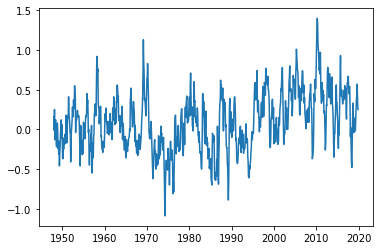

In [9]:
plt.plot(ds_tna['time'],ds_tna['tna'])

#### Composite Prep
Now we need to prepare our data to go into our composite

In [10]:
#AVISO is newer data so we should slice the TNA data to match the same times
ds_tna=ds_tna.sel(time=slice(ds_aviso['time'][0],ds_aviso['time'][-1]))
ds_tna

<xarray.Dataset>
Dimensions:  (time: 276)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
Data variables:
    tna      (time) float64 -0.25 -0.25 -0.23 -0.07 ... 0.72 0.93 0.49 0.42

<div class="alert alert-block alert-info">
Define TNA Index for Composite
</div>

In [11]:
#TNA Index has both Positive and Negative
pos_tna = ds_tna['tna'].where(ds_tna['tna']>=0)
neg_tna = ds_tna['tna'].where(ds_tna['tna']<0)

<div class="alert alert-block alert-info">
Anomolies of AVISO Altimetry data
</div>

In [12]:
ds_climo=ds_aviso.groupby('time.month').mean()
ds_anoms=ds_aviso.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 276)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sla        (time, latitude, longitude) float64 -0.01249 -0.01437 ... nan nan

#### Composite Time

In [14]:
pos_tna_sla=ds_anoms.sel(time=pos_tna.dropna(dim='time')['time']).mean(dim='time')
neg_tna_sla=ds_anoms.sel(time=neg_tna.dropna(dim='time')['time']).mean(dim='time')
comp_sla=[pos_tna_sla,neg_tna_sla]
comp_sla

[<xarray.Dataset>
 Dimensions:    (latitude: 121, longitude: 1440)
 Coordinates:
   * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
   * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
 Data variables:
     sla        (latitude, longitude) float64 0.002038 0.002181 ... nan nan,
 <xarray.Dataset>
 Dimensions:    (latitude: 121, longitude: 1440)
 Coordinates:
   * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
   * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
 Data variables:
     sla        (latitude, longitude) float64 -0.007337 -0.007851 ... nan nan]

Text(0.5, 0.98, 'Composite of Sea Level Anomalies and Tropical North Atlantic SST')

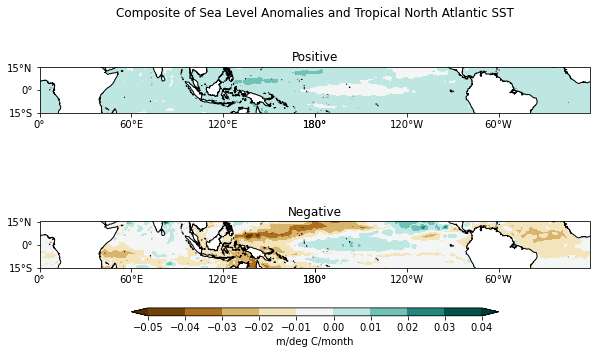

In [22]:
labels=['Positive','Negative']
clevs=np.arange(-0.05,0.05,0.01)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(8.5,5.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_sla):

        # Select the season
        data=comp_sla[i]['sla']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=comp_sla[i]['longitude'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_sla[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-15,16,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m/deg C/month')

# Add a big title at the top
plt.suptitle('Composite of Sea Level Anomalies and Tropical North Atlantic SST')
